# Quantum Espresso Energy Volume Curve Workflow with jobflow

## Define workflow with jobflow

In [1]:
import numpy as np

In [2]:
from jobflow import job, Flow

/home/jan/mambaforge/lib/python3.12/site-packages/paramiko/pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
/home/jan/mambaforge/lib/python3.12/site-packages/paramiko/transport.py:253: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,


In [3]:
from python_workflow_definition.jobflow import write_workflow_json

In [4]:
from quantum_espresso_workflow import (
    calculate_qe as _calculate_qe, 
    generate_structures as _generate_structures, 
    get_bulk_structure as _get_bulk_structure, 
    plot_energy_volume_curve as _plot_energy_volume_curve,
)

In [5]:
workflow_json_filename = "jobflow_qe.json"

In [6]:
calculate_qe = job(_calculate_qe, data=["energy", "volume", "structure"])
generate_structures = job(_generate_structures, data=[f"s_{i}" for i in range(100)])
plot_energy_volume_curve = job(_plot_energy_volume_curve)
get_bulk_structure = job(_get_bulk_structure)

In [7]:
pseudopotentials = {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}

In [8]:
structure = get_bulk_structure(
    element="Al",
    a=4.05,
    cubic=True,
)

In [9]:
calc_mini = calculate_qe(
    working_directory="mini",
    input_dict={
        "structure": structure.output,
        "pseudopotentials": pseudopotentials,
        "kpts": (3, 3, 3),
        "calculation": "vc-relax",
        "smearing": 0.02,
    },
)

In [10]:
number_of_strains = 5
structure_lst = generate_structures(
    structure=calc_mini.output.structure,
    strain_lst=np.linspace(0.9, 1.1, number_of_strains),
)

In [11]:
job_strain_lst = []
for i in range(number_of_strains):
    calc_strain = calculate_qe(
        working_directory="strain_" + str(i),
        input_dict={
            "structure": getattr(structure_lst.output, f"s_{i}"),
            "pseudopotentials": pseudopotentials,
            "kpts": (3, 3, 3),
            "calculation": "scf",
            "smearing": 0.02,
        },
    )
    job_strain_lst.append(calc_strain)

In [12]:
plot = plot_energy_volume_curve(
    volume_lst=[job.output.volume for job in job_strain_lst],
    energy_lst=[job.output.energy for job in job_strain_lst],
)

In [13]:
flow = Flow([structure, calc_mini, structure_lst] + job_strain_lst + [plot])

In [14]:
write_workflow_json(flow=flow, file_name=workflow_json_filename)

In [15]:
!cat {workflow_json_filename}

{"nodes": {"0": "quantum_espresso_workflow.get_bulk_structure", "1": "quantum_espresso_workflow.calculate_qe", "2": "quantum_espresso_workflow.generate_structures", "3": "quantum_espresso_workflow.calculate_qe", "4": "quantum_espresso_workflow.calculate_qe", "5": "quantum_espresso_workflow.calculate_qe", "6": "quantum_espresso_workflow.calculate_qe", "7": "quantum_espresso_workflow.calculate_qe", "8": "quantum_espresso_workflow.plot_energy_volume_curve", "9": "Al", "10": 4.05, "11": true, "12": "mini", "13": "python_workflow_definition.shared.get_dict", "14": {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}, "15": [3, 3, 3], "16": "vc-relax", "17": 0.02, "18": [0.9, 0.9500000000000001, 1.0, 1.05, 1.1], "19": "strain_0", "20": "python_workflow_definition.shared.get_dict", "21": "scf", "22": "strain_1", "23": "python_workflow_definition.shared.get_dict", "24": "strain_2", "25": "python_workflow_definition.shared.get_dict", "26": "strain_3", "27": "python_workflow_definition.shared.get_dict", "28":

## Load Workflow with aiida

In [16]:
from aiida import load_profile

load_profile()

Profile<uuid='c08748df7ab74ec08c14e5f16cebc987' name='pwd'>

In [17]:
from python_workflow_definition.aiida import load_workflow_json

In [18]:
wg = load_workflow_json(workflow_json_filename)

In [19]:
wg

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'WorkGra…

In [20]:
result = wg.run()

03/22/2025 05:25:44 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|continue_workgraph]: tasks ready to run: pickle_node10,pickle_node11,pickle_node12,pickle_node13,pickle_node15,pickle_node16,pickle_node17,pickle_node18,pickle_node19,pickle_node20,pickle_node22,pickle_node23,pickle_node25,pickle_node27,pickle_node29
03/22/2025 05:26:05 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|on_wait]: Process status: Waiting for child processes: 335, 342, 349, 356, 363, 370, 377, 384, 391, 398, 405, 412, 419, 426, 433
03/22/2025 05:27:16 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|update_task_state]: Task: pickle_node10, type: PYTHONJOB, finished.
03/22/2025 05:27:16 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|update_task_state]: Task: pickle_node11, type: PYTHONJOB, finished.


invalid state


03/22/2025 05:27:17 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|update_task_state]: Task: pickle_node12, type: PYTHONJOB, finished.


invalid state


03/22/2025 05:27:17 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|update_task_state]: Task: pickle_node13, type: PYTHONJOB, finished.


invalid state


03/22/2025 05:27:18 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|update_task_state]: Task: pickle_node15, type: PYTHONJOB, finished.


invalid state


03/22/2025 05:27:18 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|update_task_state]: Task: pickle_node16, type: PYTHONJOB, finished.


invalid state


03/22/2025 05:27:19 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|update_task_state]: Task: pickle_node17, type: PYTHONJOB, finished.


invalid state


03/22/2025 05:27:19 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|update_task_state]: Task: pickle_node18, type: PYTHONJOB, finished.


invalid state


03/22/2025 05:27:20 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|update_task_state]: Task: pickle_node19, type: PYTHONJOB, finished.


invalid state


03/22/2025 05:27:20 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|update_task_state]: Task: pickle_node20, type: PYTHONJOB, finished.


invalid state


03/22/2025 05:27:21 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|update_task_state]: Task: pickle_node22, type: PYTHONJOB, finished.


invalid state


03/22/2025 05:27:21 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|update_task_state]: Task: pickle_node23, type: PYTHONJOB, finished.


invalid state


03/22/2025 05:27:22 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|update_task_state]: Task: pickle_node25, type: PYTHONJOB, finished.


invalid state


03/22/2025 05:27:22 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|update_task_state]: Task: pickle_node27, type: PYTHONJOB, finished.


invalid state


03/22/2025 05:27:23 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|update_task_state]: Task: pickle_node29, type: PYTHONJOB, finished.


invalid state


03/22/2025 05:27:29 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|continue_workgraph]: tasks ready to run: get_bulk_structure1
03/22/2025 05:27:31 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|on_wait]: Process status: Waiting for child processes: 500
03/22/2025 05:27:43 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|update_task_state]: Task: get_bulk_structure1, type: PYTHONJOB, finished.
03/22/2025 05:27:48 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|continue_workgraph]: tasks ready to run: get_dict14
03/22/2025 05:27:51 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|on_wait]: Process status: Waiting for child processes: 511
03/22/2025 05:28:02 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [3

invalid state


03/22/2025 05:29:53 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|update_task_state]: Task: get_dict26, type: PYTHONJOB, finished.


invalid state


03/22/2025 05:29:53 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|update_task_state]: Task: get_dict28, type: PYTHONJOB, finished.


invalid state


03/22/2025 05:29:54 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|update_task_state]: Task: get_dict30, type: PYTHONJOB, finished.


invalid state


03/22/2025 05:29:59 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|continue_workgraph]: tasks ready to run: calculate_qe4,calculate_qe5,calculate_qe6,calculate_qe7,calculate_qe8
03/22/2025 05:30:07 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|on_wait]: Process status: Waiting for child processes: 603, 610, 617, 624, 631
03/22/2025 05:30:41 PM <77053> aiida.parser.PythonJobParser: [WARNING] Found extra results that are not included in the output: dict_keys(['structure'])
03/22/2025 05:30:42 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|update_task_state]: Task: calculate_qe4, type: PYTHONJOB, finished.
03/22/2025 05:30:47 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|continue_workgraph]: tasks ready to run: 
03/22/2025 05:30:50 PM <77053> aiida.orm.nodes.process.workflow.workcha

invalid state


03/22/2025 05:31:17 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|update_task_state]: Task: calculate_qe8, type: PYTHONJOB, finished.


invalid state


03/22/2025 05:31:22 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|continue_workgraph]: tasks ready to run: get_list31,get_list32
03/22/2025 05:31:27 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|on_wait]: Process status: Waiting for child processes: 663, 670
03/22/2025 05:31:42 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|update_task_state]: Task: get_list31, type: PYTHONJOB, finished.
03/22/2025 05:31:42 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|update_task_state]: Task: get_list32, type: PYTHONJOB, finished.


invalid state


03/22/2025 05:31:47 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|continue_workgraph]: tasks ready to run: plot_energy_volume_curve9
03/22/2025 05:31:50 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|on_wait]: Process status: Waiting for child processes: 685
03/22/2025 05:32:04 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|update_task_state]: Task: plot_energy_volume_curve9, type: PYTHONJOB, finished.
03/22/2025 05:32:09 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|continue_workgraph]: tasks ready to run: 
03/22/2025 05:32:11 PM <77053> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [328|WorkGraphEngine|finalize]: Finalize workgraph.


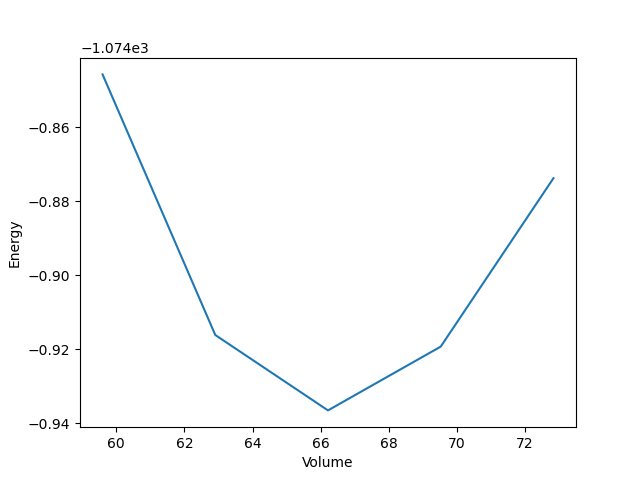

In [21]:
from IPython.display import Image, display

plot_task = [t for t in wg.tasks if t.name.startswith('plot_energy_volume_curve')][0]
plot_file = f"{plot_task.node.get_remote_workdir()}/evcurve.png"

display(Image(filename=str(plot_file)))


## Load Workflow with pyiron_base

In [22]:
from pyiron_base import Project

In [23]:
from python_workflow_definition.pyiron_base import load_workflow_json

In [24]:
pr = Project("test")
pr.remove_jobs(recursive=True, silently=True)

0it [00:00, ?it/s]

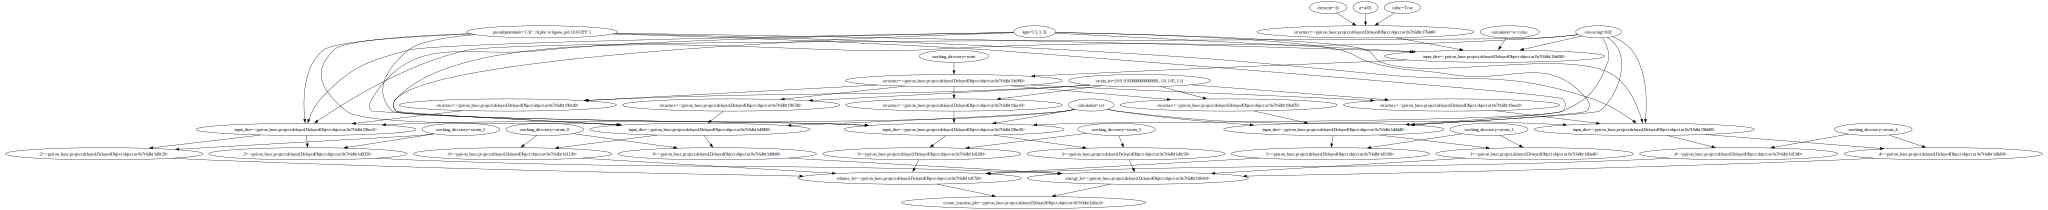

In [25]:
delayed_object = load_workflow_json(project=pr, file_name=workflow_json_filename)
delayed_object.draw()

The job get_bulk_structure_f1e730ed97e30e5439e855d2ac41396f was saved and received the ID: 8
The job get_dict_1e47509b88d63a21fd421686554c8f4a was saved and received the ID: 9
The job calculate_qe_e3c0bf43f7edf24d215901bf93271e87 was saved and received the ID: 10


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job generate_structures_6326b8ea2e84f099ea95fec76459bc56 was saved and received the ID: 11
The job get_dict_27e8162e8ea354dae951497ba9e7b9dd was saved and received the ID: 12
The job calculate_qe_1bf9ad9fb363acc8d268f1e80ed53382 was saved and received the ID: 13


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_3e0ebfe87008f5e62291452793644d90 was saved and received the ID: 14
The job calculate_qe_b6c10ce0f5581c5163295b4ddf908191 was saved and received the ID: 15


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_e59211242612ae95433521ef6b374e6f was saved and received the ID: 16
The job calculate_qe_5be20ee465cbcc51f54d4167a9f081ae was saved and received the ID: 17


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_9dd0bb1e6343ccf9acbdb1bea11bd506 was saved and received the ID: 18
The job calculate_qe_0e5300454c9d12e36c6d2925c2e6d859 was saved and received the ID: 19


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_da6f93cd2ef0e45bdf569b708131d0a6 was saved and received the ID: 20
The job calculate_qe_326496dc7db0f79fde4d7e1abe2eedf3 was saved and received the ID: 21


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_list_09ab4d5239e439dc9eb2292db9516c04 was saved and received the ID: 22
The job get_list_30bb97099893030717e722ed661022c7 was saved and received the ID: 23
The job plot_energy_volume_curve_e82d98c6a163e43fe8943f89cb94dee9 was saved and received the ID: 24


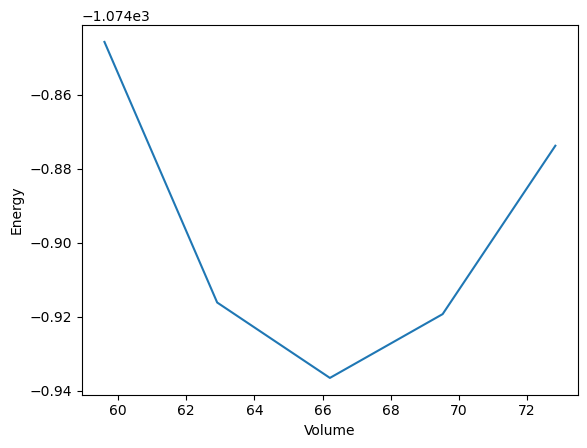

In [26]:
delayed_object.pull()